# Financial Investment Planning

## Introduction

A financial strategy produces orders. These orders are transmitted to a broker. The broker checks the validity of the order and sends each valid order to the market and sends back a transaction. Every time we buy some shares the broker opens a position with the buy price. If we sell some shares this should be related to a position in order to calculate the profit. Therefore the position information is important mainly in order to calculate profit. We call a buy/sell matching a trade. The sum of all positions are called the portfolio. 

<img src="https://docs.google.com/drawings/d/1XKseqFtXRjTvju0UYBn6F29NqVp5zTGbdUZouDNpa8w/pub?w=1238&amp;h=402">

#### Assumptions for this notebook

+ no user account information
+ stock market (consisting of 23 symbols),
+ only market orders,
+ no short positions, 
+ the price is determined by the historical *daily* candle data.

# TableOfContents
+ [Order and Transaction](#OrderAndTransaction)
+ [Portfolio](#Portfolio)
+ [Dividend and Split](#DividendAndSplit)
+ [Rebalance](#Rebalance)
+ [Backtest](#Backtest)
+ [Index Calculation](#IndexCalculation)
+ [Risk Calculation](#RiskCalculation)
+ [Visualization](#Visualization)
+ [To Do](#ToDo)

## Symbol, the price of a symbol
*Symbols* are the financial instrument that we can invest in. At a given point, there is no known price but the price depends on the buyers' and sellers' bid prices. The price of a symbol is **calculated** by the market for a given order. Therefore the price of a symbol may change constantly. Usually symbols have *candle data* (5min, 1day) etc.. storing open, close, low and high values.

In [2]:
import pandas as pd
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import datetime
import warnings
from copy import deepcopy
import numpy as np
%matplotlib inline
from scipy.stats import linregress
import matplotlib.pyplot as plt
from math import sqrt
import scipy.stats as st

/home/can/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
symbols = ['AEFES.IS', 'AKENR.IS', 'AKSA.IS', 'AKBNK.IS', 'GARAN.IS',
           'MGROS.IS', 'THYAO.IS', 'TRKCM.IS', 'ZOREN.IS', 'XU100.IS', 
           'ALARK.IS', 'CIMSA.IS',  'HALKB.IS', 'TKFEN.IS', 'FROTO.IS', 
           'DOAS.IS', 'KARSN.IS', 'TMSN.IS', 'YKBNK.IS', 'VAKBN.IS', 
           'ULKER.IS', 'TCELL.IS', 'SISE.IS', 'EREGL.IS', 'PETKM.IS', 
           'BJKAS.IS', 'AFYON.IS', 'KOZAL.IS', 'GOODY.IS', 'VAKFN.IS']

start = datetime.datetime(2015,1,1)
end = datetime.datetime.now()

In [4]:
prices = pd.DataFrame()
for symbol in symbols:
    f = web.DataReader(symbol, 'yahoo', start, end)
    f['symbol'] = symbol
    prices = pd.concat([prices, f])
prices;

How do I calculae the adjusted closing price?
http://www.investopedia.com/ask/answers/06/adjustedclosingprice.asp

- **cash dividend (d)**:  closing_price - d
- **share dividend (x:y)**: closing_price* (y+x)/x
- **share split (x:y)**: closing_price * y/x

In [5]:
prices = prices.pivot(columns="symbol", values="Adj Close")

In [6]:
prices.tail()

symbol,AEFES.IS,AFYON.IS,AKBNK.IS,AKENR.IS,AKSA.IS,ALARK.IS,BJKAS.IS,CIMSA.IS,DOAS.IS,EREGL.IS,...,THYAO.IS,TKFEN.IS,TMSN.IS,TRKCM.IS,ULKER.IS,VAKBN.IS,VAKFN.IS,XU100.IS,YKBNK.IS,ZOREN.IS
Date,,,,,,,,,,,,,,,,,,,,,
2016-09-26,18.70,5.69,7.96,0.94,8.20,3.44,4.58,14.92,9.93,4.28,...,5.12,7.37,7.51,2.44,21.44,4.43,1.17,76725.7031,3.66,1.57
2016-09-27,18.69,5.72,8.13,0.95,8.20,3.45,4.72,14.98,9.92,4.24,...,5.13,7.53,7.51,2.43,21.08,4.54,1.17,77160.7031,3.70,1.58
2016-09-28,18.49,5.85,8.31,0.95,8.27,3.52,4.76,15.08,9.97,4.20,...,5.16,7.49,7.52,2.45,21.24,4.70,1.18,77677.7969,3.76,1.60
2016-09-29,18.40,6.19,8.13,0.96,8.20,3.59,4.41,15.07,9.93,4.19,...,5.16,7.70,7.56,2.48,21.22,4.62,1.17,77076.7969,3.70,1.60
2016-09-30,18.17,6.30,8.04,0.95,8.16,3.57,4.26,14.89,10.05,4.13,...,5.14,7.72,7.53,2.49,21.38,4.59,1.18,76488.3984,3.67,1.59


In [7]:
dividends_and_splits= pd.DataFrame()

for symbol in symbols:
    f = web.DataReader(symbol, 'yahoo-actions')
    if len(f) > 0:
        f['symbol'] = symbol
        dividends_and_splits = pd.concat([dividends_and_splits, f])

In [8]:
Splits = dividends_and_splits[dividends_and_splits["action"] == 'SPLIT']
Dividends = dividends_and_splits[dividends_and_splits["action"] == 'DIVIDEND']
Splits

,action,value,symbol
2013-06-26,SPLIT,0.869565,THYAO.IS
2011-07-11,SPLIT,0.833333,THYAO.IS
2013-07-03,SPLIT,0.980392,TRKCM.IS
2012-07-16,SPLIT,0.869565,TRKCM.IS
2010-11-25,SPLIT,0.500000,DOAS.IS
2013-07-04,SPLIT,0.961538,SISE.IS
2012-07-10,SPLIT,0.909091,SISE.IS
2011-06-20,SPLIT,0.884956,SISE.IS
2013-04-12,SPLIT,0.884956,EREGL.IS
2012-04-30,SPLIT,0.699301,EREGL.IS


In [9]:
Dividends.head()

,action,value,symbol
2016-05-30,DIVIDEND,0.245,AEFES.IS
2015-05-29,DIVIDEND,0.460,AEFES.IS
2013-05-30,DIVIDEND,0.450,AEFES.IS
2012-05-29,DIVIDEND,0.450,AEFES.IS
2011-05-27,DIVIDEND,0.480,AEFES.IS


## OrderAndTransaction
[TOC](#TableOfContents)

We give an *order* buy/sell a symbol of some amount of *shares* to a *brocker* which accepts this order and transmit to the market. The response of an order is a *transaction* and it contains the status of the orders, the price and the commissions.

In [10]:
order = {'symbol':'AKBNK.IS', 
         'shares':100, 
         'action':'buy', 
         'time':'2016-05-12'}

transaction = {'status':'accepted', 
               'symbol': 'GARAN', 
               'action':'buy', 
               'shares':100, 
               'price':5.2, 
               'commision':2, 
               'time':'2016-05-13'}

In real situation, when we pass the order to a brocker, the brocker responds with a transaction. We will simulate this situation with the following function.

In [11]:
# TODO: check user account's free cash and update it accordingly
def execute_order(order, holdings):
    'Simulates the broker/market and creates a transaction.'
    transaction = deepcopy(order)
    symbol, shares, time = order['symbol'], order['shares'], order['time']
    
    if order['action']=='sell':
        if (holdings is None or  
            not (symbol in holdings.index) or 
            holdings.loc[symbol]['shares'] < order['shares']):
            
            warnings.warn('Your order ' + str(order) + ' is rejected.')
            transaction['status'] = 'rejected'
            return transaction
    
    transaction['status'] = 'accepted'
    price = get_price(symbol, time)
    commision = commision_calculation(order, price)
    transaction['price'], transaction['commision'] = price, commision
    return transaction

def get_price(symbol, time = None, price_source=prices):
    'Returns the last price of the symbol. We assume that prices is a pandas object.'
    if time is None:
        time = str(datetime.datetime.now())
    
    try: 
        closest_time = (price_source.index[time >= price_source.index]).sort_values()[-1]
        return price_source[symbol].loc[closest_time]
    except ValueError:
        raise ValueError("We don't have historical data for an order at " + order_time)
    except IndexError:
        raise IndexError("We don't have historical data for an order at " + order_time)

def commision_calculation(order, price, commission_ratio=0.0001):
    'Calculates commision to be paid.'
    return order['shares']*price*commission_ratio

def current_time(prices=prices):
    'Returns the maximum date from the prices table.'
    return max(prices.index).strftime("%Y-%m-%d")

In [12]:
execute_order(order, [])

{'action': 'buy',
 'commision': 0.076999999999999999,
 'price': 7.7000000000000002,
 'shares': 100,
 'status': 'accepted',
 'symbol': 'AKBNK.IS',
 'time': '2016-05-12'}

TODO: make a real example

## Positions and Trades

Every time we have an accepted buy order we create a *position*. A trade is a *matching* of buy/sell transactions of the same symbol. We need these trade objects in order to calculate the *current* cost of the portfolio and realized profits. 

Example
---
Transactions
+ $t_1$: (GARAN, buy, 100, 7.02)
+ $t_2$: (GARAN, buy, 200, 7.05)
+ $t_3$: (GARAN, sell, 150, 7.10)

Cost
+ $t_1$: 702
+ $t_2$: 702 + 1410
+ $t_3$: 702 + 1410 - $x $

In order to calculate $x $, we need to match the sell order at *t3* with the buy orders *t1* and *t2*. For the matching we assume first-in first-out rule. We first match the sell order at *t3* with the buy order at *t1* and then the remaining with the order at *t2*.

In [13]:
def apply_transaction(transaction, positions, trades):
    'Update positions and trades with the transaction.'
    if transaction["status"] == "accepted":
        symbol, action, shares = transaction["symbol"], transaction["action"], transaction["shares"]
        price, time = transaction["price"], transaction['time']
        if action == "buy":
            position = {'type':'long', 
                        'symbol':symbol, 
                        'initial_shares':shares, 
                        'shares':shares, 
                        'price': price, 
                        'cost': price*shares, 
                        'time': time}
            positions.append(position)
        else:
            match_sell_transaction_to_position(transaction, positions, trades)

def match_sell_transaction_to_position(transaction, positions, trades):
    """We will select the positions with the same symbol and order them according to time desc.
    Until we finish the order's volume we match it with a position. If a position is fulfilled,
    we continue with the next one in the order. We create a trade, we remove the amount traded 
    from the position. If the position's volume is empty we remove the position from the list.
    
    Assumption: Since the broker rejects sells orders greater then our holdings, 
    we assume that transaction.shares <= sum(positions.shares)."""
    
    sorted(positions, key=lambda k: k['time']) 
    shares, time, symbol = transaction["shares"], transaction["time"], transaction["symbol"]
    
    for position in positions:
        if not shares > 0:
            break
        if position["symbol"] == transaction["symbol"] and position["shares"] > 0:
            traded_shares = min(shares, position['shares'])
            buy_price, sell_price = position["price"], transaction["price"]
            profit = (sell_price - buy_price) * traded_shares
            trade = {'symbol':symbol, 
                     'shares':traded_shares, 
                     'time':time, 
                     'buy_price': buy_price, 
                     'sell_price': sell_price, 
                     'profit': profit}
            trades.append(trade)
            shares -= traded_shares
            position["shares"] = position["shares"] - traded_shares
            position["cost"] = position["shares"] * buy_price

In [14]:
def calculate_portfolio(positions):
    if len(positions) == 0:
        return []
    else:
        temp = pd.DataFrame(positions)
        return temp.pivot_table(index='symbol', aggfunc='sum', values=["cost", 'shares'])

In [15]:
orders = [
    {'symbol':'GARAN.IS', 'shares':100, 'action':'buy', 'time':'2016-05-15 10:00:00'},
    {'symbol':'GARAN.IS', 'shares':100, 'action':'buy', 'time':'2016-05-20 11:00:00'},
    {'symbol':'GARAN.IS', 'shares':120, 'action':'sel', 'time':'2016-05-22 09:50:00'},
    {'symbol':'AKBNK.IS', 'shares':100, 'action':'buy', 'time':'2016-05-20 16:30:00'}, 
    {'symbol':'AKBNK.IS', 'shares':100, 'action':'buy', 'time':'2016-05-21 10:57:23'},
    {'symbol':'AKBNK.IS', 'shares':220, 'action':'buy', 'time':'2016-05-24 10:00:00'},
    {'symbol':'AKBNK.IS', 'shares':200, 'action':'sell', 'time':'2016-05-24 12:00:00'},
    {'symbol':'AKBNK.IS', 'shares':110, 'action':'sell', 'time':'2016-05-27 00:00:00'},
    {'symbol':'ZOREN.IS', 'shares':50, 'action':'sell', 'time':'2016-05-28 00:00:00'},
]

pd.DataFrame(orders)

,action,shares,symbol,time
0,buy,100,GARAN.IS,2016-05-15 10:00:00
1,buy,100,GARAN.IS,2016-05-20 11:00:00
2,sel,120,GARAN.IS,2016-05-22 09:50:00
3,buy,100,AKBNK.IS,2016-05-20 16:30:00
4,buy,100,AKBNK.IS,2016-05-21 10:57:23
5,buy,220,AKBNK.IS,2016-05-24 10:00:00
6,sell,200,AKBNK.IS,2016-05-24 12:00:00
7,sell,110,AKBNK.IS,2016-05-27 00:00:00
8,sell,50,ZOREN.IS,2016-05-28 00:00:00


# Account

In [16]:
def execute_orders(orders, transactions, positions, trades):
    """Calls execute_order function for each order in the order list.
    Updates transaction, position and trade lists.
    """
    
    portfolio = calculate_portfolio(positions)
    for order in orders:
        transaction = execute_order(order, portfolio)
        transactions.append(transaction)
        apply_transaction(transaction, positions, trades)
        portfolio = calculate_portfolio(positions)

In [17]:
transactions, positions, trades = [], [], []
execute_orders(orders, transactions, positions, trades);

/home/can/.local/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Your order {'action': 'sell', 'symbol': 'ZOREN.IS', 'shares': 50, 'time': '2016-05-28 00:00:00'} is rejected.


In [18]:
pd.DataFrame(transactions)

,action,commision,price,shares,status,symbol,time
0,buy,0.07510,7.51,100,accepted,GARAN.IS,2016-05-15 10:00:00
1,buy,0.07250,7.25,100,accepted,GARAN.IS,2016-05-20 11:00:00
2,sel,0.08700,7.25,120,accepted,GARAN.IS,2016-05-22 09:50:00
3,buy,0.07500,7.50,100,accepted,AKBNK.IS,2016-05-20 16:30:00
4,buy,0.07500,7.50,100,accepted,AKBNK.IS,2016-05-21 10:57:23
5,buy,0.17710,8.05,220,accepted,AKBNK.IS,2016-05-24 10:00:00
6,sell,0.16100,8.05,200,accepted,AKBNK.IS,2016-05-24 12:00:00
7,sell,0.08745,7.95,110,accepted,AKBNK.IS,2016-05-27 00:00:00
8,sell,NaN,NaN,50,rejected,ZOREN.IS,2016-05-28 00:00:00


In [19]:
def summary(transactions, positions, trades):
    print "***Transactions***".center(70)
    print '-' * 70
    print pd.DataFrame(transactions)
    print ''

    print "***Positions***".center(70)
    print '-' * 70
    print pd.DataFrame(positions)
    print ''

    print "***Trades***".center(70)
    print '-' * 70
    print pd.DataFrame(trades)

summary(transactions, positions, trades)

                          ***Transactions***                          
----------------------------------------------------------------------
  action  commision  price  shares    status    symbol                 time
0    buy    0.07510   7.51     100  accepted  GARAN.IS  2016-05-15 10:00:00
1    buy    0.07250   7.25     100  accepted  GARAN.IS  2016-05-20 11:00:00
2    sel    0.08700   7.25     120  accepted  GARAN.IS  2016-05-22 09:50:00
3    buy    0.07500   7.50     100  accepted  AKBNK.IS  2016-05-20 16:30:00
4    buy    0.07500   7.50     100  accepted  AKBNK.IS  2016-05-21 10:57:23
5    buy    0.17710   8.05     220  accepted  AKBNK.IS  2016-05-24 10:00:00
6   sell    0.16100   8.05     200  accepted  AKBNK.IS  2016-05-24 12:00:00
7   sell    0.08745   7.95     110  accepted  AKBNK.IS  2016-05-27 00:00:00
8   sell        NaN    NaN      50  rejected  ZOREN.IS  2016-05-28 00:00:00

                           ***Positions***                            
--------------------------

## Portfolio
[TOC](#TableOfContents)

An *asset* is financial instruments that we own. The assets can be calculated using transaction reports. *Market value* is the current value of an asset. It represent the value as if we want to sell the asset right now. It is calculated by some estimation of the current price of the corresponding symbol. The collection of assets that we own are called our *portfolio*. 

##### Portfolio Market Value

In [20]:
portfolio = calculate_portfolio(positions)
portfolio

,cost,shares
symbol,,
AKBNK.IS,885.5,110
GARAN.IS,580.0,80


In [21]:
x = pd.Series({"GARAN.IS": get_price("GARAN.IS"), "AKBNK.IS": get_price("AKBNK.IS")})

In [22]:
portfolio["current_price"] = x

In [23]:
portfolio["shares"] * portfolio["current_price"]

symbol
AKBNK.IS    884.4
GARAN.IS    636.0
dtype: float64

In [24]:
def get_prices(assets, time = None):
    return {symbol: get_price(symbol, time) for symbol in assets}

pd.Series(get_prices(portfolio.index))

AKBNK.IS    8.04
GARAN.IS    7.95
dtype: float64

In [25]:
portfolio["shares"] / 2

symbol
AKBNK.IS    55.0
GARAN.IS    40.0
Name: shares, dtype: float64

In [26]:
def current_performance(portfolio, time=None):
    portfolio["current_price"] = pd.Series(get_prices(portfolio.index, time))
    portfolio["market_value"] = portfolio["shares"] * portfolio["current_price"]
    portfolio["profit"] = portfolio["market_value"] - portfolio["cost"]
    
    total_market_value = portfolio.market_value.sum()
    portfolio["weight"] = portfolio["market_value"] / total_market_value

In [27]:
current_performance(portfolio)
portfolio

,cost,shares,current_price,market_value,profit,weight
symbol,,,,,,
AKBNK.IS,885.5,110,8.04,884.4,-1.1,0.581689
GARAN.IS,580.0,80,7.95,636.0,56.0,0.418311


In [28]:
def historical_performance(transactions, prices):
    "Returns historical market value of a portfolio."
    starting_date = min(transactions, key=lambda x: x["time"])["time"]
    ending_date = datetime.datetime.now()
    symbols = set([t["symbol"] for t in transactions if t["status"]=="accepted"] )
    
    symbol_price = (prices.loc[starting_date:ending_date][list(symbols)])
    
    holdings_list = holdings(transactions)
    
    return (holdings_list
            .fillna(method='ffill')
            .reindex(symbol_price.index.union(holdings_list.index))
            .fillna(method='ffill')
            .reindex(symbol_price.index)
            .mul(symbol_price).sum(axis=1)
           )

def holdings(transactions):
    t = pd.DataFrame(transactions)
    t["sign"] = t["action"].apply(lambda x: 1 if x=="buy" else -1)
    t["signed_shares"] = t["sign"] * t["shares"]
    t["time"] = pd.to_datetime(t["time"])
    
    return (t.query("status == 'accepted'")
     .pivot_table(values="signed_shares", columns="symbol", index="time")
     .cumsum()
    )

In [29]:
symbols = set([t["symbol"] for t in transactions if t["status"]=="accepted"] )
starting_date = min(transactions, key=lambda x: x["time"])["time"]
ending_date = datetime.datetime.now()
symbol_price = (prices.loc[starting_date:ending_date][list(symbols)])

In [30]:
def compare_with_benchmark(historical_value, benchmark_symbol="XU100.IS"):
    algo = (historical_value[historical_value > 0].pct_change() + 1).cumprod()
    algo.name = "Algorithm"
    algo.plot(legend=True)
    print "Algorithm performance:", (algo.ix[-1] - 1)*100
    
    start_date = historical_value.index[0]

    benchmark = (prices[benchmark_symbol].dropna().pct_change().loc[start_date:] + 1).cumprod()
    benchmark.name = "Benchmark"
    benchmark.plot(legend = True, figsize=[15,10])
    print "Benchmark performance:", (benchmark.ix[-1] - 1)*100

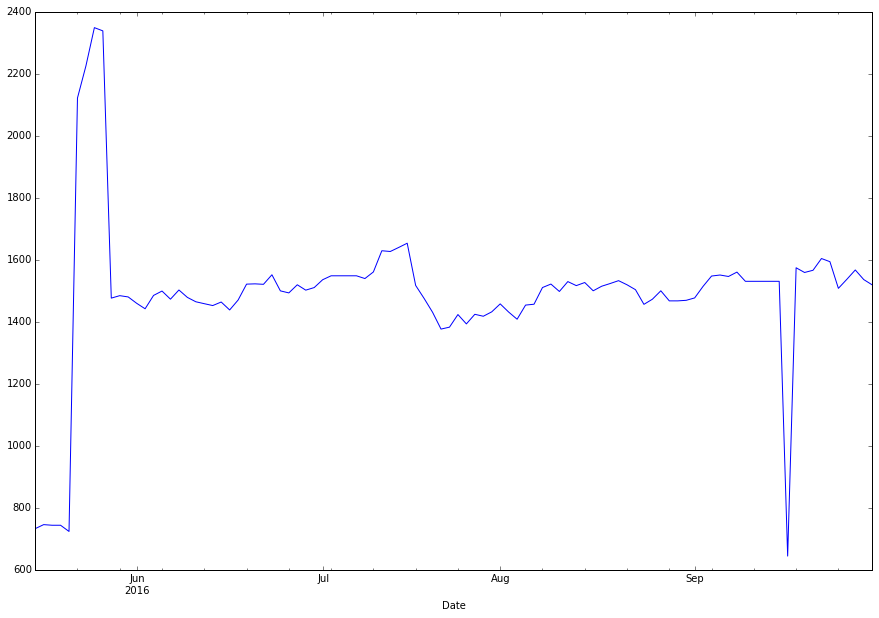

In [31]:
historical_performance(transactions, prices).plot(figsize= [15,10])

## DividendAndSplit
[TOC](#TableOfContents)

In [32]:
def paid_dividends(transactions, dividends):
    
    start_date = min(transactions, key=lambda x: x["time"])["time"]
    end_date = datetime.datetime.now()
    
    H= holdings(transactions)
    H.index = pd.to_datetime(H.index)
    
    H = (H.reindex(pd.date_range(start=start_date, end=end_date, freq='D'))
         .fillna(method='ffill')
         .fillna(0))
    
    return (pd.melt(Dividends[Dividends.symbol.apply(lambda x: x in H.columns)]
                    .reset_index()
                    .rename(columns={'index':'time'})
                    .pivot_table(values="value", columns="symbol", index = 'time')
                    .reindex(H.index)
                    .mul(H)
                    .reset_index()
                    .rename(columns={'index':'time'})
                    , id_vars = 'time', var_name= 'symbol', value_name='paid_dividend'
                    )
            ).query("paid_dividend > 0")

In [33]:
paid_dividends(transactions, Dividends)

,time,symbol,paid_dividend


## Rebalance
[TOC](#TableOfContents)

In [34]:
def rebalance(portfolio, target_weights, target_value = None, time = None):
    """New weights is a dictionary of {symbol: weights}.
    Creates orders to make portfolio's weight 'new weights'.
    Time indicates execution of rebalance operation.
    """
    if time is None:
        time = current_time()
    
    if target_value is None: 
        target_value = portfolio.market_value.sum()
        
    if len(portfolio)>0:
        target_weights = {s:target_weights[s] if s in target_weights.keys() else 0 
                          for s in set(portfolio.index | target_weights.keys())}
        
    # check if the weights sum up to 1.
    assert(sum(target_weights.values()) == 1)
        
    rebalance_orders = []
    
    target_market_value = {s:target_weights[s]*target_value for s in target_weights.keys()}
    
    for symbol, weight in target_weights.iteritems():
        
        if len(portfolio)>0 and symbol in portfolio.index:
            delta_value = target_market_value[symbol] - portfolio["market_value"].loc[symbol]
            
            if weight:
                delta_lot = int(abs(delta_value / get_price(symbol, time)))
            else:
                delta_lot = portfolio["shares"].loc[symbol]
            
            if delta_lot:
                if delta_value > 0:
                    action = 'buy'
                else:
                    action = 'sell'
            
                order = {'symbol': symbol, 'shares': delta_lot, 'action': action, 'time': time}
                rebalance_orders.append(order)
        else:
            delta_lot = int(target_market_value[symbol] / get_price(symbol, time))
            order = {'symbol': symbol, 'shares': delta_lot, 'action': 'buy', 'time': time}
            rebalance_orders.append(order) 
    
    return rebalance_orders

In [35]:
portfolio

,cost,shares,current_price,market_value,profit,weight
symbol,,,,,,
AKBNK.IS,885.5,110,8.04,884.4,-1.1,0.581689
GARAN.IS,580.0,80,7.95,636.0,56.0,0.418311


In [36]:
portfolio["market_value"].loc['AKBNK.IS']

884.39999999999986

In [37]:
orders_to_rebalance = rebalance(portfolio, {"AKBNK.IS":0.50, "GARAN.IS": 0.20, "ZOREN.IS": 0.30 })
pd.DataFrame(orders_to_rebalance)

,action,shares,symbol,time
0,sell,41,GARAN.IS,2016-09-30
1,buy,286,ZOREN.IS,2016-09-30
2,sell,15,AKBNK.IS,2016-09-30


In [38]:
execute_orders(orders_to_rebalance, transactions, positions, trades)
summary(transactions, positions, trades)

                          ***Transactions***                          
----------------------------------------------------------------------
   action  commision  price  shares    status    symbol                 time
0     buy   0.075100   7.51     100  accepted  GARAN.IS  2016-05-15 10:00:00
1     buy   0.072500   7.25     100  accepted  GARAN.IS  2016-05-20 11:00:00
2     sel   0.087000   7.25     120  accepted  GARAN.IS  2016-05-22 09:50:00
3     buy   0.075000   7.50     100  accepted  AKBNK.IS  2016-05-20 16:30:00
4     buy   0.075000   7.50     100  accepted  AKBNK.IS  2016-05-21 10:57:23
5     buy   0.177100   8.05     220  accepted  AKBNK.IS  2016-05-24 10:00:00
6    sell   0.161000   8.05     200  accepted  AKBNK.IS  2016-05-24 12:00:00
7    sell   0.087450   7.95     110  accepted  AKBNK.IS  2016-05-27 00:00:00
8    sell        NaN    NaN      50  rejected  ZOREN.IS  2016-05-28 00:00:00
9    sell   0.032595   7.95      41  accepted  GARAN.IS           2016-09-30
10    buy  

In [39]:
portfolio = calculate_portfolio(positions)
portfolio

,cost,shares
symbol,,
AKBNK.IS,764.75,95
GARAN.IS,282.75,39
ZOREN.IS,454.74,286


In [40]:
current_performance(portfolio)
portfolio

,cost,shares,current_price,market_value,profit,weight
symbol,,,,,,
AKBNK.IS,764.75,95,8.04,763.80,-0.95,0.499676
GARAN.IS,282.75,39,7.95,310.05,27.30,0.202834
ZOREN.IS,454.74,286,1.59,454.74,0.00,0.297490


In [41]:
portfolio, transactions, positions, trades = [], [], [], []

orders_to_rebalance = rebalance([], {'AKBNK.IS': 0.50, 'GARAN.IS': 0.50}, 1000000)
pd.DataFrame(orders_to_rebalance)

,action,shares,symbol,time
0,buy,62893,GARAN.IS,2016-09-30
1,buy,62189,AKBNK.IS,2016-09-30


In [42]:
execute_orders(orders_to_rebalance, transactions, positions, trades)
summary(transactions, positions, trades)

                          ***Transactions***                          
----------------------------------------------------------------------
  action  commision  price  shares    status    symbol        time
0    buy  49.999935   7.95   62893  accepted  GARAN.IS  2016-09-30
1    buy  49.999956   8.04   62189  accepted  AKBNK.IS  2016-09-30

                           ***Positions***                            
----------------------------------------------------------------------
        cost  initial_shares  price  shares    symbol        time  type
0  499999.35           62893   7.95   62893  GARAN.IS  2016-09-30  long
1  499999.56           62189   8.04   62189  AKBNK.IS  2016-09-30  long

                             ***Trades***                             
----------------------------------------------------------------------
Empty DataFrame
Columns: []
Index: []


In [43]:
portfolio = calculate_portfolio(positions)
current_performance(portfolio)
portfolio

,cost,shares,current_price,market_value,profit,weight
symbol,,,,,,
AKBNK.IS,499999.56,62189,8.04,499999.56,0.0,0.5
GARAN.IS,499999.35,62893,7.95,499999.35,0.0,0.5


# Backtest
[TOC](#TableOfContents)

<img src="https://docs.google.com/drawings/d/1_85KGJuBXS-LS1301OM5NjgLLK42Rw1s-uVmgNU3GaQ/pub?w=900&amp;h=217">

## Algoritm Example: Beta

- Repeat each month the following procedure:
    - Calculate beta values of each stocks against BIST 100 index. **time window** *for beta calculation?*
    - Choose 10 stocks with the highest beta value.
    - Rebalance the portfolio to be equal weight. 

In [44]:
capital_base = 100000
start, end = np.datetime64('2016-01-20 00:00:00'), np.datetime64('2016-07-18 00:00:00')
running_points = [date for date in prices.index if start <= date <= end]

http://markets.ft.com/data/lexicon/term/beta

We use Beta 5Y from the Multex Ratios and Statistics table, which is provided to us by Reuters. The Market Guide Beta is the slope of the 60 month regression line of the percentage price change of the stock relative to the percentage price change of the S&P 500. Beta values are not calculated if less than 24 months of pricing is available.

In [45]:
def beta(price_data, start, end):
    returns = (prices.loc[start:end]
               .resample('3BMS', 'first')
               .pct_change()
               .dropna())
    
    beta_values = {symbol: linregress(returns["XU100.IS"], returns[symbol])[0] 
                   for symbol in price_data.columns if symbol != 'XU100.IS'}
    return beta_values

In [46]:
portfolio, transactions, positions, trades = [], [], [], []

for t in running_points:
    time = t.strftime("%Y-%m-%d")
    
    if t in pd.date_range(start=running_points[0], periods=12, freq='BM'):
        print t
        print '-'*20
        beta_values = beta(prices, prices.index[0], t)
        for s in sorted(beta_values, key=beta_values.get, reverse=True):
            print s, beta_values[s]
            
        n = 5    
        new_weights = {s: 1./n for s in sorted(beta_values, key=beta_values.get, reverse=True)[:n]}
        print new_weights
        
        target_value = None if len(portfolio) else capital_base
        
        if len(portfolio) > 0:
            current_performance(portfolio, time)
        
        rebalance_orders = rebalance(portfolio, new_weights, target_value, time)
        
        print "Before Orders"
        print "-"*20
        print portfolio
        print " "
        
        print "Orders"
        print "-"*20
        print pd.DataFrame(rebalance_orders)
        print " "
        execute_orders(rebalance_orders, transactions, positions, trades)
        portfolio = calculate_portfolio(positions)
        current_performance(portfolio, time)
        
        print "After Orders"
        print "-"*20 
        print portfolio
        print " "
        
portfolio = calculate_portfolio(positions)

2016-01-29 00:00:00
--------------------
AFYON.IS 56.9642159504
GOODY.IS 6.87604665207
DOAS.IS 5.19504241764
AEFES.IS 3.51989365886
KOZAL.IS 3.3448762139
AKSA.IS 3.12012336438
EREGL.IS 2.84900427814
SISE.IS 2.51218079997
TCELL.IS 2.10369051414
FROTO.IS 2.09457851314
PETKM.IS 1.81512146095
TRKCM.IS 1.48578088376
THYAO.IS 1.18962314346
MGROS.IS 1.15606357034
TKFEN.IS 1.00811513171
GARAN.IS 1.00615148771
AKBNK.IS 0.886587616544
YKBNK.IS 0.867160616649
HALKB.IS 0.855486536853
ALARK.IS 0.820330070269
VAKBN.IS 0.750041809138
ZOREN.IS 0.646334486257
VAKFN.IS 0.251506076805
CIMSA.IS -0.00851550187079
AKENR.IS -0.796155439582
ULKER.IS -1.00029164062
KARSN.IS -1.51552933437
TMSN.IS -1.73699367046
BJKAS.IS -3.00339814457
{'DOAS.IS': 0.2, 'AFYON.IS': 0.2, 'AEFES.IS': 0.2, 'KOZAL.IS': 0.2, 'GOODY.IS': 0.2}
Before Orders
--------------------
[]
 
Orders
--------------------
  action  shares    symbol        time
0    buy    2059   DOAS.IS  2016-01-29
1    buy    3384  AFYON.IS  2016-01-29
2    buy  

/home/can/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  app.launch_new_instance()


In [47]:
summary(transactions, positions, trades)

                          ***Transactions***                          
----------------------------------------------------------------------
   action   commision     price  shares    status    symbol        time
0     buy    1.999145   9.70930    2059  accepted   DOAS.IS  2016-01-29
1     buy    1.999944   5.91000    3384  accepted  AFYON.IS  2016-01-29
2     buy    1.999940  18.05000    1108  accepted  AEFES.IS  2016-01-29
3     buy    1.998876  12.54000    1594  accepted  KOZAL.IS  2016-01-29
4     buy    1.999999   0.04795  417101  accepted  GOODY.IS  2016-01-29
5     buy    0.024204  10.08480      24  accepted   DOAS.IS  2016-02-29
6     buy    0.077740   5.98000     130  accepted  AFYON.IS  2016-02-29
7     buy    0.219042  16.98000     129  accepted  AEFES.IS  2016-02-29
8    sell    0.485576  16.24000     299  accepted  KOZAL.IS  2016-02-29
9     buy    0.163744   0.04646   35244  accepted  GOODY.IS  2016-02-29
10    buy    0.356533  11.24710     317  accepted   DOAS.IS  2016-

In [48]:
current_performance(portfolio, time = '2016-08-04')
portfolio

,cost,shares,current_price,market_value,profit,weight
symbol,,,,,,
AEFES.IS,0.00000,0,20.14,0.00,0.00000,0.000000
AFYON.IS,308103.77000,52642,5.48,288478.16,-19625.61000,0.190931
BJKAS.IS,266715.82000,82831,4.25,352031.75,85315.93000,0.232994
DOAS.IS,0.00000,0,10.29,0.00,0.00000,0.000000
EREGL.IS,292085.36292,70794,4.67,330607.98,38522.61708,0.218815
GOODY.IS,71296.46670,86573,3.58,309931.34,238634.87330,0.205130
KOZAL.IS,309575.29000,22579,10.18,229854.22,-79721.07000,0.152130


In [49]:
portfolio.market_value.sum()

1510903.45

In [50]:
paid_dividends(transactions, Dividends)

,time,symbol,paid_dividend
816,2016-04-07,DOAS.IS,3.272736e+03
1113,2016-05-25,EREGL.IS,1.892700e+03
1362,2016-05-25,GOODY.IS,1.720580e+06


In [51]:
dividends_and_splits.query("symbol == 'GOODY.IS'")

,action,value,symbol
2016-06-01,SPLIT,0.045455,GOODY.IS
2016-05-25,DIVIDEND,5.528110,GOODY.IS
2015-05-20,DIVIDEND,0.794024,GOODY.IS
2015-05-12,DIVIDEND,0.794024,GOODY.IS
2014-05-06,DIVIDEND,5.243630,GOODY.IS
2013-05-16,DIVIDEND,0.833000,GOODY.IS
2012-05-31,DIVIDEND,1.035160,GOODY.IS
2011-05-26,DIVIDEND,0.230000,GOODY.IS


Algorithm performance: 1565.96392855
Benchmark performance: 5.60699416203


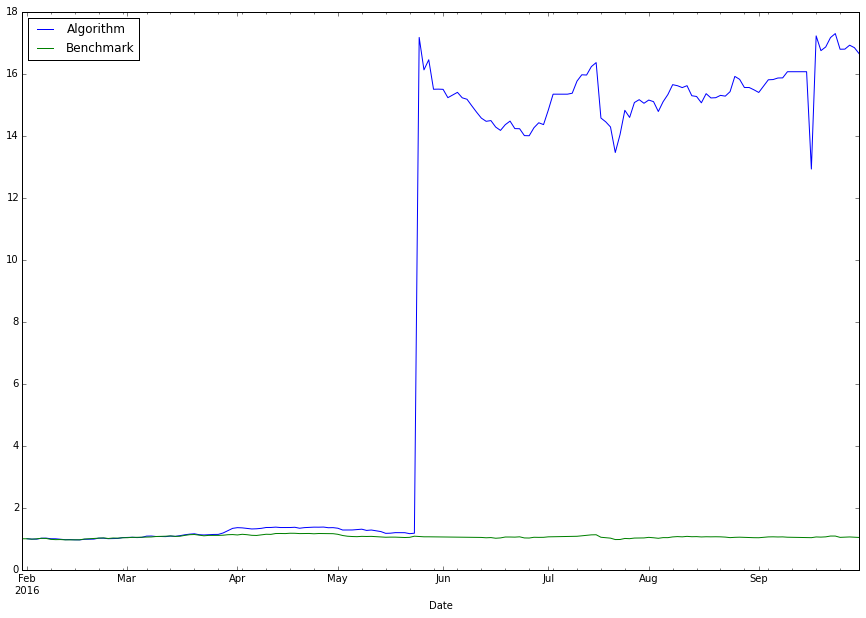

In [52]:
temp = historical_performance(transactions, prices)
compare_with_benchmark(temp)

## Momentum Strategy

**Initialization** 
1. Calculate absolute momentum (return) of funds and select *n* stocks with the highest moment.
2. Equal weight

**Every month**
1. If the moment of a stock in the portfolio is negative then replace it with the best option
2. Rebalance

In [53]:
# TODO: fill nan values
def momentum(price_data, start, end):
    momentum_values = {symbol: (price_data[symbol].loc[end] - price_data[symbol].loc[start]) 
                   for symbol in price_data.columns if symbol != 'XU100.IS'}
    return momentum_values

In [54]:
pd.date_range(start=running_points[0], periods=12, freq='BM')

DatetimeIndex(['2016-01-29', '2016-02-29', '2016-03-31', '2016-04-29',
               '2016-05-31', '2016-06-30', '2016-07-29', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-30'],
              dtype='datetime64[ns]', freq='BM')

In [55]:
portfolio, transactions, positions, trades = [], [], [], []

for t in running_points:
    time = t.strftime("%Y-%m-%d")
    
    if t in pd.date_range(start=running_points[0], periods=12, freq='BM'):
        print t
        print '-'*20
        momentum_values = momentum(prices, t - pd.DateOffset(months=5) - 1*BDay(), t - 1*BDay())
        for s in sorted(momentum_values, key=momentum_values.get, reverse=True):
            print s, momentum_values[s]
            
        n = 5    
        
        if len(portfolio) == 0:
            new_weights = {s: 1./n for s in sorted(momentum_values, key=momentum_values.get, reverse=True)[:n]}
            print new_weights
            target_value = capital_base
            rebalance_orders = rebalance(portfolio, new_weights, target_value, time)
        else:
            potentials = {key:value for key, value in momentum_values.iteritems() if key not in portfolio.index }
            new_weights = {}
            
            for symbol in portfolio.index:
                if portfolio["market_value"].loc[symbol]:
                    if momentum_values[symbol] < 0:
                        s = sorted(potentials, key=potentials.get, reverse=True)[0]
                        print symbol + "out" + s + "in"
                        new_weights[s] = 1./n
                        del potentials[s]
                    else:
                        new_weights[symbol] = 1./n
              
            current_performance(portfolio, time)
            
            print new_weights
            rebalance_orders = rebalance(portfolio, new_weights, None, time)      
        
        print "Before Orders"
        print "-"*20
        print portfolio["market_value"].sum() if len(portfolio) else 0
        print portfolio
        print " "
        
        print "Orders"
        print "-"*20
        print pd.DataFrame(rebalance_orders)
        print " "
        
        print sum([order["shares"]*get_price(order["symbol"], time) for order in rebalance_orders if order["action"]=="buy"])
        print sum([order["shares"]*get_price(order["symbol"], time) for order in rebalance_orders if order["action"]=="sell"])
        
        execute_orders(rebalance_orders, transactions, positions, trades)
        portfolio = calculate_portfolio(positions)
        current_performance(portfolio, time)
        
        print "After Orders"
        print "-"*20 
        print portfolio
        print portfolio["market_value"].sum()
        print " "
        
portfolio = calculate_portfolio(positions)

2016-01-29 00:00:00
--------------------
TMSN.IS 4.5
FROTO.IS 2.4809
BJKAS.IS 1.02
PETKM.IS 0.83363
AFYON.IS 0.61
ALARK.IS 0.54994
ULKER.IS 0.39
ZOREN.IS 0.23881
AKBNK.IS 0.14716
SISE.IS 0.10687
YKBNK.IS 0.06
VAKFN.IS 0.0523
GARAN.IS 0.039
KARSN.IS 0.03
GOODY.IS 0.00778
AKSA.IS 0.0
AKENR.IS -0.01
TRKCM.IS -0.04577
VAKBN.IS -0.05946
TKFEN.IS -0.11
CIMSA.IS -0.6547
MGROS.IS -0.7
THYAO.IS -0.73
EREGL.IS -0.76409
HALKB.IS -0.79
TCELL.IS -1.23
DOAS.IS -1.7434
AEFES.IS -2.81
KOZAL.IS -12.3
{'AFYON.IS': 0.2, 'TMSN.IS': 0.2, 'BJKAS.IS': 0.2, 'FROTO.IS': 0.2, 'PETKM.IS': 0.2}
Before Orders
--------------------
0
[]
 
Orders
--------------------
  action  shares    symbol        time
0    buy    3384  AFYON.IS  2016-01-29
1    buy    1901   TMSN.IS  2016-01-29
2    buy    6734  BJKAS.IS  2016-01-29
3    buy     636  FROTO.IS  2016-01-29
4    buy    6250  PETKM.IS  2016-01-29
 
99982.3716
0
After Orders
--------------------
                cost  shares  current_price  market_value  profit    weig

In [56]:
summary(transactions, positions, trades)

                          ***Transactions***                          
----------------------------------------------------------------------
   action  commision     price  shares    status    symbol        time
0     buy   1.999944   5.91000    3384  accepted  AFYON.IS  2016-01-29
1     buy   1.999852  10.52000    1901  accepted   TMSN.IS  2016-01-29
2     buy   1.999998   2.97000    6734  accepted  BJKAS.IS  2016-01-29
3     buy   1.998668  31.42560     636  accepted  FROTO.IS  2016-01-29
4     buy   1.999775   3.19964    6250  accepted  PETKM.IS  2016-01-29
5     buy   0.217074   5.98000     363  accepted  AFYON.IS  2016-02-29
6    sell   0.910260   4.68000    1945  accepted  BJKAS.IS  2016-02-29
7     buy   0.381420   9.78000     390  accepted   TMSN.IS  2016-02-29
8     buy   0.078097  33.95520      23  accepted  FROTO.IS  2016-02-29
9     buy   0.229446   3.21803     713  accepted  PETKM.IS  2016-02-29
10   sell   0.039494   6.37000      62  accepted  AFYON.IS  2016-03-31
11   s

In [57]:
current_performance(portfolio, time = '2016-07-18')
portfolio 

,cost,shares,current_price,market_value,profit,weight
symbol,,,,,,
AFYON.IS,0.00000,0,5.14,0.00,0.00000,0.000000
BJKAS.IS,17145.16000,5628,3.90,21949.20,4804.04000,0.222960
FROTO.IS,20056.52640,638,32.32,20620.16,563.63360,0.209459
KOZAL.IS,26849.84000,1534,10.63,16306.42,-10543.42000,0.165641
PETKM.IS,16286.48111,5086,3.94,20038.84,3752.35889,0.203554
TMSN.IS,0.00000,0,7.10,0.00,0.00000,0.000000
ULKER.IS,20720.40000,930,21.00,19530.00,-1190.40000,0.198386


In [58]:
portfolio["market_value"].sum()

98444.62

In [59]:
paid_dividends(transactions, Dividends)

,time,symbol,paid_dividend
564,2016-04-04,FROTO.IS,650.00
1146,2016-06-27,PETKM.IS,1624.14


Algorithm performance: 13.1896335214
Benchmark performance: 5.60699416203


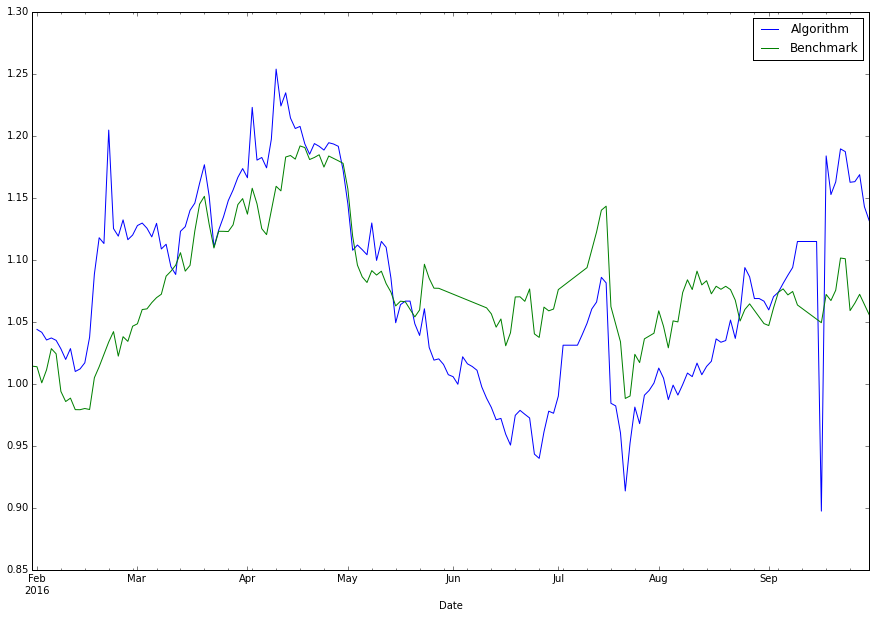

In [60]:
temp = historical_performance(transactions, prices)
compare_with_benchmark(temp)

## IndexCalculation
[TOC](#TableOfContents)

We can withdraw / deposit money into the portfolio or while rebalancing some amount of free cash can left. In this kind of situations it is hard to calculate the performance of a portfolio. To overcome this situation one way is to calculate an index value and to calculate performance over this index value instead of market value.

In [61]:
historical_performance(pd.DataFrame(transactions)[0:5].to_dict("records"), prices)["2016-02-25":"2016-03-02"]

Date
2016-02-25    113231.4596
2016-02-26    111634.3921
2016-02-29    112051.4147
2016-03-01    113060.0381
2016-03-02    113371.5324
dtype: float64

In [62]:
historical_performance(transactions, prices)["2016-02-25":"2016-03-02"]

Date
2016-02-25    113231.45960
2016-02-26    111634.39210
2016-02-29    112009.17969
2016-03-01    112774.81843
2016-03-02    112975.15510
dtype: float64

In [63]:
pd.pivot_table(pd.DataFrame(transactions), values="shares", index="time", columns="symbol")

symbol,AFYON.IS,BJKAS.IS,FROTO.IS,KOZAL.IS,PETKM.IS,TMSN.IS,ULKER.IS
time,,,,,,,
2016-01-29,3384.0,6734.0,636.0,NaN,6250.0,1901.0,NaN
2016-02-29,363.0,1945.0,23.0,NaN,713.0,390.0,NaN
2016-03-31,62.0,141.0,9.0,NaN,565.0,406.0,NaN
2016-04-29,3685.0,112.0,26.0,1281.0,193.0,2697.0,1052.0
2016-05-31,NaN,1720.0,48.0,185.0,1049.0,NaN,107.0
2016-06-30,NaN,628.0,62.0,68.0,70.0,NaN,15.0


## RiskCalculation
[TOC](#TableOfContents)

### Value-at-Risk

The value-at-risk is a measure of how much money can be lost for a period of time. Of course there is a (very small) probability that we can lost **all** our money. We can talk about the distrubition of the money that we can lost. For the value-at-risk we choose a probability say 99% and say that we will not loose money more then $ x $ with probability 99%. 


There can be different methods to *estimate* the *risk*:
* Historical method:
* The Variance-Covariance Method:
* Simulation:


One way of chosing a methods is to test against historical data which is called *backtesting*.

In [64]:
from matplotlib.dates import AutoDateLocator
from matplotlib.ticker import MultipleLocator

-0.072105940035707305

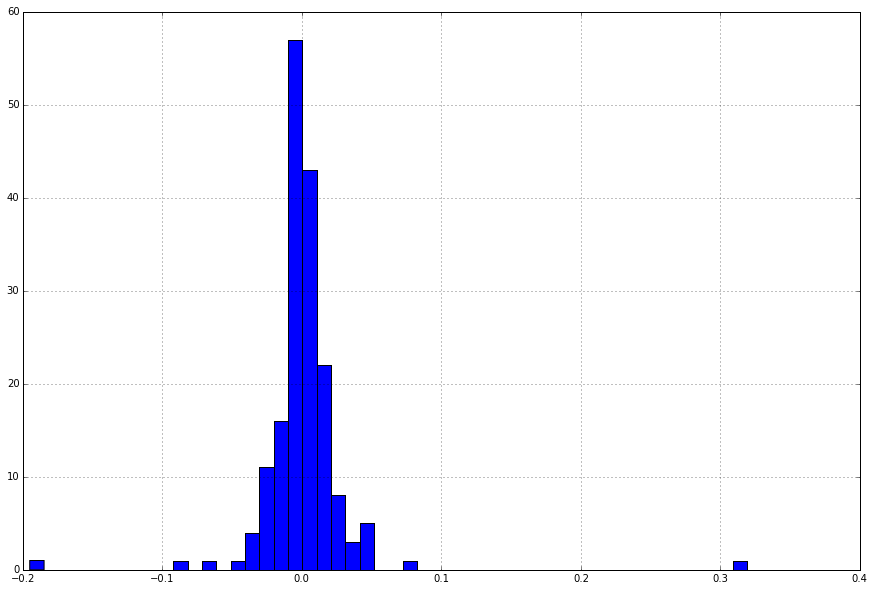

In [65]:
# Historical method
returns = historical_performance(transactions, prices).pct_change().dropna()
returns.hist(bins=50, figsize=(15,10))
var_historic = returns.quantile(q = 0.01)
var_historic

In [66]:
# The Variance-Covariance Method
mu = np.mean(returns)
sigma = np.std(returns)
var_parametric = st.norm.ppf(0.01) * sigma
var_parametric

-0.079391854933226536

In [67]:
# Monte Carlo Simulation

samples = np.random.normal(mu, sigma, 100)
var_montecarlo = np.percentile(samples, 0.01)
var_montecarlo

-0.09693688460895461

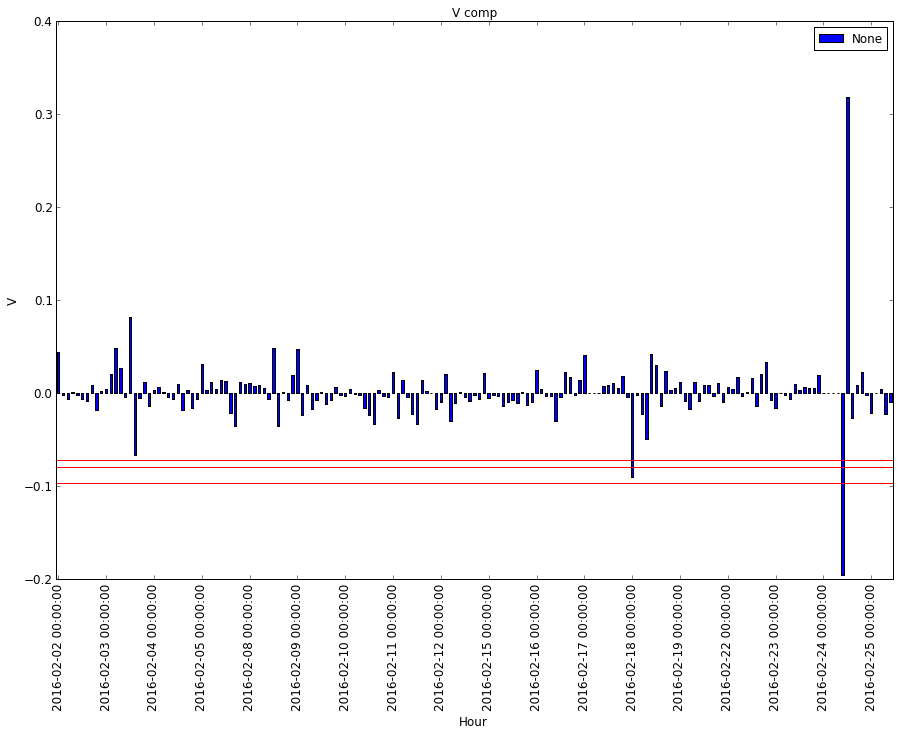

In [68]:
ax = returns.plot(kind='bar', title ="V comp",figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel("Hour",fontsize=12)
AutoDateLocator()
loc = MultipleLocator(base=10.0)
ax.xaxis.set_major_locator(loc)
ax.set_ylabel("V",fontsize=12)
plt.axhline(y=var_historic, color='r', linestyle='-')
plt.axhline(y=var_parametric, color='r', linestyle='-')
plt.axhline(y=var_montecarlo, color='r', linestyle='-')
plt.show()

### Stress Testing

### Risk Profile

The risk profile is a way of categorizing portfolios according their risk. Risk profile of a portfolio depends on its *yearly volatility*. The yearly volatily is calculated by multiplying the standard deviation of weekly returns by square root of 52 (number of weeks in a year).

Cutoff points for yearly volatility is: [0, 0.5, 2, 5, 10, 15, 25]

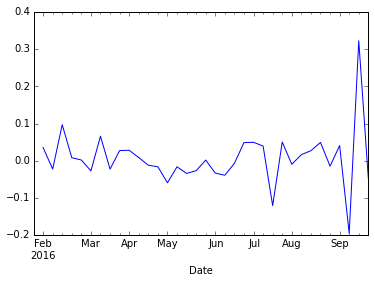

In [69]:
historical_performance(transactions, prices).pct_change().resample("W-MON", label="left" ,closed="left").sum().plot()

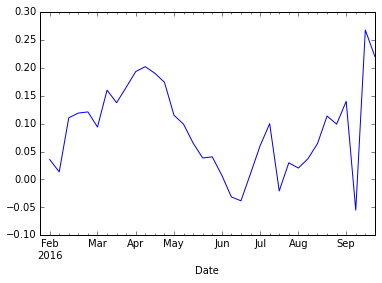

In [70]:
historical_performance(transactions, prices).pct_change().resample("W-MON", label="left" ,closed="left").sum().cumsum().plot()

In [71]:
def calculate_risk_value(historical_prices):
    return np.std((historical_prices.pct_change() + 1).resample("W-MON", label="left" ,closed="left").prod() - 1) * sqrt(52)

risk_value = calculate_risk_value(historical_performance(transactions, prices)) * 100

In [72]:
from bisect import bisect
RiskLevels = [0, 0.5, 2, 5, 10, 15, 25]
bisect(RiskLevels, risk_value)

7

## Visualization
[TOC](#TableOfContents)

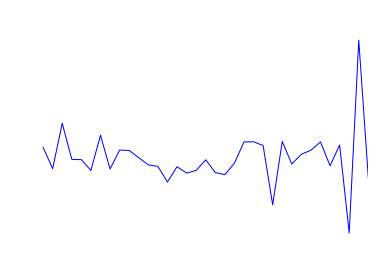

In [73]:
#sparkline
historical_prices = historical_performance(transactions, prices)
weekly_returns = ((historical_prices.pct_change() + 1).resample("W-MON", label="left" ,closed="left").prod() - 1)
plt.plot(weekly_returns)
plt.axis("off");
plt.savefig("trend.png")

## ToDo
[TOC](#TableOfContents)

###### Overview

- Order lifecycle
- Transaction and position
- Strategies: Technical vs Fundemantal
- Trading algorithms from interactive brokers

###### Dividend and Split
- Implied transactions

###### Portfolio Calculation

- plot stock prices annotated by dividend and splits
- compute dividend and split automatically: 
    + get close prices (not adjusted)
    + create split and dividend transactions?
    + calculate event-adjusted share count
    + calculate paid dividend

###### Algorithm

- blacklist for algorithms
- parameter search

###### Index Calculation
- Overview
- index normalization

###### Risk Calculation
- Value at Risk

###### Misc
- styling